In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import normalize, StandardScaler
import os
import cv2
import numpy as np
from mahotas.features import zernike_moments
import time
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import logging
import joblib

In [2]:
# EXTRACTOR SETTING
HOG_PARAM = {'pixels_per_cell': (4, 4), 'cells_per_block': (1, 1)}
LPB_PARAM = {'radius': 1, 'n_points': 8, 'method': 'uniform'}
SIFT_PARAM = {'thresh': 5}   # Lower threshold to detect more keypoints
# SURF_PARAM = {'hessianThreshold': 100}  # Reduce threshold to detect weak features
# ORB_PARAM = {'nfeatures': 100}  # Fewer features due to small image size
GLCM_PARAM = {
    'distances': [1, 2],  
    'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4],  # orientations（0°, 45°, 90°, 135°）
    'properties': ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
}

# MODEL SETTING
CLASSIFIERS = {
        "SVM": SVC(kernel='linear'),
        "Naive Bayes": GaussianNB(),
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(),
        # "LightGBM": lgb.LGBMClassifier()  # Uncomment if using LightGBM
    }
PARAM_GRIDS = {
        "SVM": {},
        "Naive Bayes": {}, #
        "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
        "KNN": {'n_neighbors': [3, 5, 7]},
        # "LightGBM": {'num_leaves': [31, 50], 'learning_rate': [0.01, 0.05], 'n_estimators': [100]}  
    }

In [3]:
#Preparing the dataset
train_path = r"C:\Users\81903\Desktop\coursework\thesis\6. repo\IMGRECO\week3-replicate\report\datasets\mnist\equalized_train_images_labels-m"
test_path = r"C:\Users\81903\Desktop\coursework\thesis\6. repo\IMGRECO\week3-replicate\report\datasets\mnist\equalized_test_images_labels-m"
models = {}

image_path_train = []
for i in range(10):
    dir = os.path.join(train_path, str(i))
    for file in os.listdir(dir):
        image_path_train.append(os.path.join(dir, file))


image_path_test = []
for i in range(10):
    dir = os.path.join(test_path, str(i))
    for file in os.listdir(dir):
        image_path_test.append(os.path.join(dir, file))

# Create a log file for recording training results
log_filename = "training_log_Handcrafted_MNIST.txt"
logging.basicConfig(filename=log_filename, level=logging.INFO, format="%(asctime)s - %(message)s")

# Log the start of the training process
logging.info("***************This is the logging book for MNIST datasets******************")

In [4]:
# the features extrated in this cells are all of fixed shapes 

def get_hog_features(img):
    """
    Extract HOG features from images.
    """
    pixels_per_cell= HOG_PARAM.get('pixels_per_cell')
    cells_per_block= HOG_PARAM.get('cells_per_block')

    # Ensure the image is in grayscale
    img_resized = img.astype(np.float32)
    # Extract HOG features
    features, _ = hog(
        img_resized,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=True
    )
    return features


def get_lpb_features(img ):
    """
    Extract LBP features from images.
    """
    radius = LPB_PARAM.get('radius')
    n_points = LPB_PARAM.get('n_points')
    method = LPB_PARAM.get('method')

    # Ensure the image is in grayscale
    img_resized = img.astype(np.float32)
    # Extract LBP features
    lbp = local_binary_pattern(img_resized, P=n_points, R=radius, method=method)
    # Flatten LBP into a histogram
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), density=True)
    return lbp_hist

def get_glcm_features(img):
    """
    Extract GLCM features from images.
    """
    distances = GLCM_PARAM.get('distances')
    angles = GLCM_PARAM.get('angles')
    properties = GLCM_PARAM.get('properties')

    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(np.uint8)

    glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    feature_vector = []
    for prop in properties:
        feature_vector.extend(graycoprops(glcm, prop).flatten())

    return feature_vector

# 45 dimension
def get_zernike_features(img):
    """
    Extract Zernike moments as features.
    """
    radius = 14  # Half of 28x28 image size
    features = zernike_moments(img, radius, degree=8)
    return features

def get_fix_feature(image_path, method):
    labels = []
    vec = []
    count = 0
    for file in image_path:
        img = cv2.imread(file, 0)
        img = img / 255.0
        if method == 'hog':
            img_des = get_hog_features(img)
        elif method == 'lbp':
            img_des = get_lpb_features(img)
        elif method == 'glcm':
            img_des = get_glcm_features(img)
        elif method == 'zm':
            img_des = get_zernike_features(img)
        else:
            raise ValueError("Unsupported feature extraction method.")

        if img_des is not None:
#             img_vec = bag_of_features(img_des, centres, k)
            vec.append(img_des)
            # Get the folder name and convert it to a number
            folder_name = os.path.basename(os.path.dirname(file))
            labels.append(int(folder_name))
        else:
            count = count + 1
            print(f'No feature extractedf ${count}')
    vec = np.vstack(vec)
    scaler = StandardScaler()
    feature = scaler.fit_transform(vec)

    return feature, labels

In [5]:
# SIFT features are not of fixed length, we use k-means approach

def get_SIFT_feature(image_path):
    """
    Extracts image features using SIFT and performs K-Means clustering.

    """

    # Set default parameters for feature extraction
    sift_thresh = SIFT_PARAM.get('thresh', 0)

    def CalcFeatures(img):
        
        extractor = cv2.SIFT_create(sift_thresh)
        kp, des = extractor.detectAndCompute(img, None)
        return des

    # Extract features from all images
    features = []
    for file in image_path:
        img = cv2.imread(file, 0)
        # img = img / 255.0
        img_des = CalcFeatures(img)
        if img_des is not None:
            features.append(img_des)

    # Stack all feature descriptors into a single array
    features = np.vstack(features)

    """
    Perform K-Means clustering on the extracted features.
    The cluster centers obtained will be used for feature encoding.
    """

    k = 150  # Number of clusters
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

    """
    Convert feature descriptors into a Bag of Words representation.
    Each feature is assigned to the nearest cluster center.
    """

    def bag_of_features(features, centres, k=500):
        vec = np.zeros((1, k))
        for i in range(features.shape[0]):
            feat = features[i]
            diff = np.tile(feat, (k, 1)) - centres
            dist = np.sqrt((diff ** 2).sum(axis=1))
            idx = dist.argmin()  # Get the nearest cluster index
            vec[0][idx] += 1
        return vec

    # Create feature vectors for each image
    labels = []
    vec = []
    for file in image_path:
        img = cv2.imread(file, 0)
        # img = img / 255.0
        img_des = CalcFeatures(img)
        if img_des is not None:
            img_vec = bag_of_features(img_des, centres, k)
        else:
            img_vec = np.zeros((1, k))  # Zero-padding for images with no detected keypoints
        vec.append(img_vec)

        # Extract label from the subdirectory name
        folder_name = os.path.basename(os.path.dirname(file))
        labels.append(int(folder_name))
    # Stack feature vectors into a matrix
    vec = np.vstack(vec)
    scaler = StandardScaler()
    feature = scaler.fit_transform(vec)

    return feature, labels


In [6]:
def feature_combiner(feature1, feature2, method="stand"):
    """
    Combine two features for a set of images.
    """
    combined_features = np.hstack((feature1, feature2))
    feature = normalize(combined_features, norm='l2')
    return feature

In [7]:

# def compute_flops(model, x_train):
#     """
#     Estimate Floating-Point Operations per Second (FLOPs) for models that support it.
#     Only works for models that can be converted to PyTorch.
#     """
#     try:
#         x_sample = torch.randn(1, x_train.shape[1])  # Simulate input tensor
#         macs, params = ptflops.get_model_complexity_info(model, (x_train.shape[1],), as_strings=True)
#         print(f"FLOPs: {macs}, Parameters: {params}")
#     except Exception as e:
#         print(f"Could not compute FLOPs: {e}")

def classifier_grid_search(x_train, y_train, x_test, y_test, classifiers=CLASSIFIERS, param_grids=PARAM_GRIDS):
    
    # Store the best models
    best_models = {}

    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name}...")
        logging.info(f"Training {clf_name}...")

        # Set up the grid search with 5-fold cross-validation
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[clf_name], cv=5, scoring='accuracy', n_jobs=-1)

        # Record the training time
        start_time = time.time()
        grid_search.fit(x_train, y_train)
        training_time = time.time() - start_time
        print(f"{clf_name} - Training time: {training_time:.4f} seconds")
        logging.info(f"{clf_name} - Training time: {training_time:.4f} seconds")

        # Get the best model from grid search
        best_model = grid_search.best_estimator_
        best_models[clf_name] = best_model

        # Record the inference time
        start_inference_time = time.time()
        y_pred = best_model.predict(x_test)
        inference_time = time.time() - start_inference_time
        avg_inference_time = inference_time / len(x_test)  

        print(f"{clf_name} - Inference time: {inference_time:.4f} seconds")
        print(f"{clf_name} - Average inference time per sample: {avg_inference_time:.6f} seconds")
        logging.info(f"{clf_name} - Inference time: {inference_time:.4f} seconds")
        logging.info(f"{clf_name} - Average inference time per sample: {avg_inference_time:.6f} seconds")

        # Evaluate the results
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        clf_report = classification_report(y_test, y_pred)

        print(f"{clf_name} - Accuracy: {accuracy * 100:.2f}%")
        print(f"{clf_name} - Confusion Matrix:\n{cm}")
        print(f"{clf_name} - Classification Report:\n{clf_report}")
        logging.info(f"{clf_name} - Accuracy: {accuracy * 100:.2f}%")
        logging.info(f"{clf_name} - Confusion Matrix:\n{cm}")
        logging.info(f"{clf_name} - Classification Report:\n{clf_report}")

        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'{clf_name} - Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(np.unique(y_test)))
        plt.xticks(tick_marks, tick_marks)
        plt.yticks(tick_marks, tick_marks)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.show()

    # Perform t-SNE Visualization
#     tsne_visualization(x_train, y_train)

    return best_models



def tsne_visualization(x_train, y_train, sample_size=2000):
    """
    Perform t-SNE and plot the 2D feature space with better efficiency.
    """
    print("Performing t-SNE...")

    if x_train.shape[0] > sample_size:
        idx = np.random.choice(x_train.shape[0], sample_size, replace=False)
        x_train, y_train = x_train[idx], y_train[idx]

    tsne = TSNE(n_components=2, perplexity=30, method='barnes_hut', init='pca', random_state=42)
    x_embedded = tsne.fit_transform(x_train)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y_train, cmap='jet', alpha=0.5)
    plt.colorbar(scatter, label="Classes")
    plt.title("t-SNE Visualization of Feature Space")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()


## HOG


In [8]:
# Measure time for HOG feature extraction
start = time.time()
x_train_hog, y_train_hog = get_fix_feature(image_path_train, 'hog')
x_test_hog, y_test_hog = get_fix_feature(image_path_test, 'hog')
end = time.time()
print(f"HOG feature extraction time: {end - start:.2f} seconds")
logging.info(f"HOG feature extraction time: {end - start:.2f} seconds")

HOG feature extraction time: 629.47 seconds


Training SVM...
SVM - Training time: 274.8458 seconds
SVM - Inference time: 30.1763 seconds
SVM - Average inference time per sample: 0.003018 seconds
SVM - Accuracy: 96.41%
SVM - Confusion Matrix:
[[ 969    0    1    0    0    2    3    2    3    0]
 [   0 1123    2    0    0    0    3    2    5    0]
 [   3    6 1002   11    0    0    0    6    4    0]
 [   3    0    7  972    1   14    0    2    9    2]
 [   3    3    0    1  948    1    5    2    2   17]
 [   2    0    1   21    0  864    2    0    1    1]
 [  12    3    1    1    7    5  928    0    1    0]
 [   0    8   12    9    6    2    0  972    1   18]
 [   4    2   11   14    3    8    1    4  916   11]
 [   7    6    0    6   12    7    0   14   10  947]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.94   

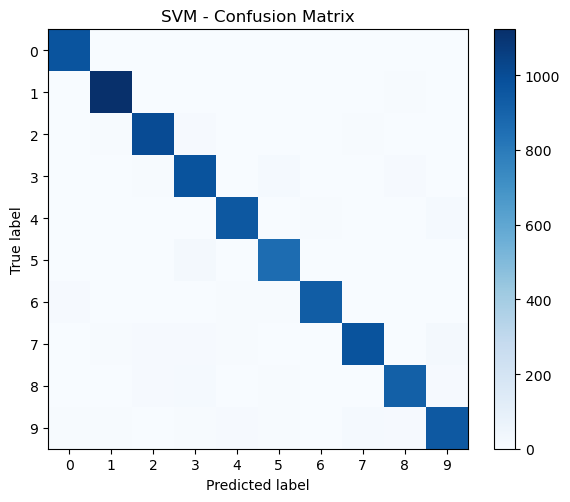

Training Naive Bayes...
Naive Bayes - Training time: 2.6309 seconds
Naive Bayes - Inference time: 0.7768 seconds
Naive Bayes - Average inference time per sample: 0.000078 seconds
Naive Bayes - Accuracy: 10.90%
Naive Bayes - Confusion Matrix:
[[   0    0  968    0   12    0    0    0    0    0]
 [   0    0 1130    0    5    0    0    0    0    0]
 [   0    0 1031    0    1    0    0    0    0    0]
 [   0    0 1006    0    1    3    0    0    0    0]
 [   0    0  921    2   59    0    0    0    0    0]
 [   0    0  759    0  133    0    0    0    0    0]
 [   0    0  949    0    9    0    0    0    0    0]
 [   0    0 1016    0   12    0    0    0    0    0]
 [   0    0  947    0   27    0    0    0    0    0]
 [   0    0 1007    0    2    0    0    0    0    0]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.11    

D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


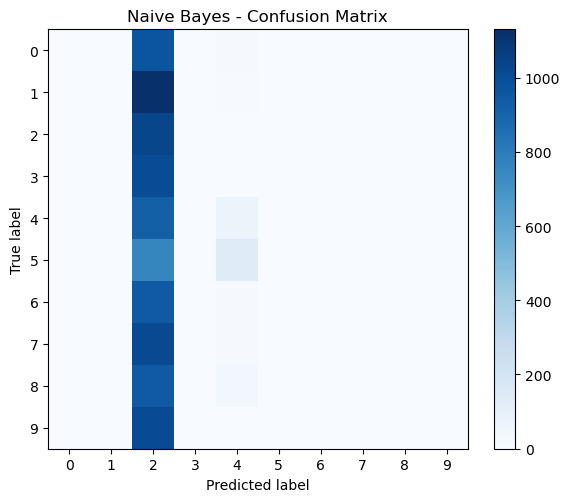

Training Random Forest...
Random Forest - Training time: 945.3392 seconds
Random Forest - Inference time: 1.1628 seconds
Random Forest - Average inference time per sample: 0.000116 seconds
Random Forest - Accuracy: 97.14%
Random Forest - Confusion Matrix:
[[ 971    3    0    0    0    1    3    0    2    0]
 [   0 1113    9    0    0    1    2    1    9    0]
 [   4    1 1015    1    1    0    3    5    2    0]
 [   0    0    3  987    0   10    0    4    4    2]
 [   1    2    2    2  948    0    5    2    1   19]
 [   2    1    0   17    1  863    5    0    2    1]
 [   7    2    0    0    2    6  939    0    2    0]
 [   1    7    9    1    5    0    0  987    2   16]
 [  11    1    4    7    4    7    0    4  935    1]
 [   8    6    3   15   10    3    0    4    4  956]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           

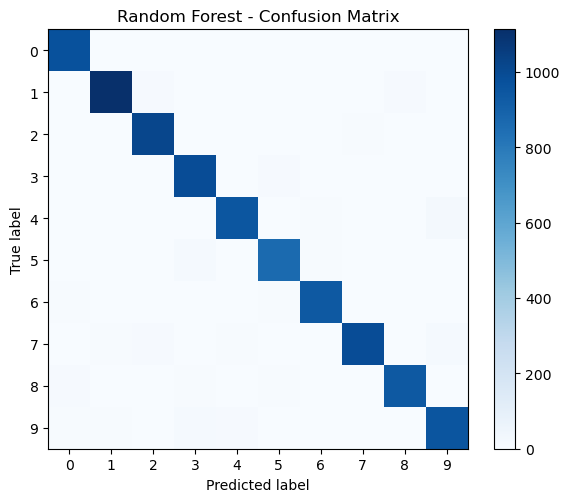

Training KNN...
KNN - Training time: 95.0857 seconds
KNN - Inference time: 8.2068 seconds
KNN - Average inference time per sample: 0.000821 seconds
KNN - Accuracy: 91.87%
KNN - Confusion Matrix:
[[ 947    2    3    3    0    4   20    1    0    0]
 [   2 1119    3    1    0    0    7    0    3    0]
 [  33   16  911   25    5    0   12   17    8    5]
 [   9    4   11  937    1    8    5   13   17    5]
 [   6   18   10    3  856    3   13   11    1   61]
 [   6    3    3   41    2  790   22    1   20    4]
 [  24    6    4    1    5   11  904    0    3    0]
 [   2   17   15    8   11    1    0  905    3   66]
 [  23    8    7   11    8   18    5    8  874   12]
 [   6    8    4    7    5    3    0   23    9  944]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       980
           1       0.93      0.99      0.96      1135
           2       0.94      0.88      0.91      1032
           3       0.90     

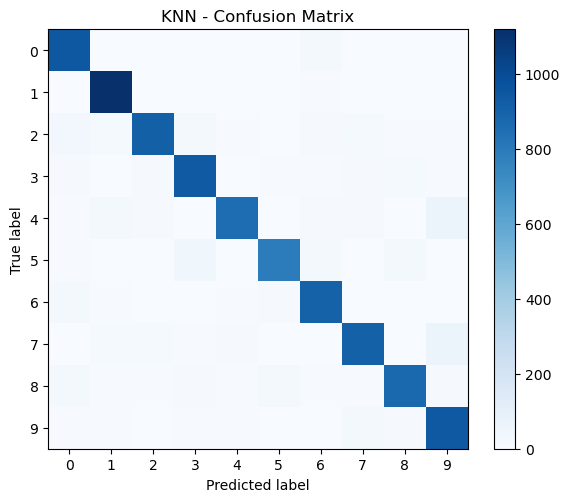

In [9]:
models_hog = classifier_grid_search(x_train_hog, y_train_hog, x_test_hog, y_test_hog)
models['models_hog'] = models_hog

## LBP


In [10]:
# Measure time for LBP feature extraction
start = time.time()
x_train_lbp, y_train_lbp = get_fix_feature(image_path_train, 'lbp')
x_test_lbp, y_test_lbp = get_fix_feature(image_path_test, 'lbp')
end = time.time()
print(f"LBP feature extraction time: {end - start:.2f} seconds")
logging.info(f"LBP feature extraction time: {end - start:.2f} seconds")

D:\software\anaconda\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
D:\software\anaconda\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP feature extraction time: 79.91 seconds


Training SVM...
SVM - Training time: 839.5776 seconds
SVM - Inference time: 30.3335 seconds
SVM - Average inference time per sample: 0.003033 seconds
SVM - Accuracy: 36.70%
SVM - Confusion Matrix:
[[ 488    2   43   88   48   43   22   25  183   38]
 [   2 1021    6    1   13    0   26   55    7    4]
 [ 241   16   90   86   67   59   99   94  180  100]
 [ 217   19   57  180  116   78   49  120   94   80]
 [  83   36   32  105  237   80   42  188   53  126]
 [ 150   32   43  115  115  107   35  152   52   91]
 [ 190   21   54   68   45   26  172   55  158  169]
 [  27  137   22   78  135   49   25  469   26   60]
 [ 170   11   36   27   19    7   70    8  582   44]
 [ 102   12   47   95  101   60   77   95   96  324]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.50      0.37       980
           1       0.78      0.90      0.84      1135
           2       0.21      0.09      0.12      1032
           3       0.21   

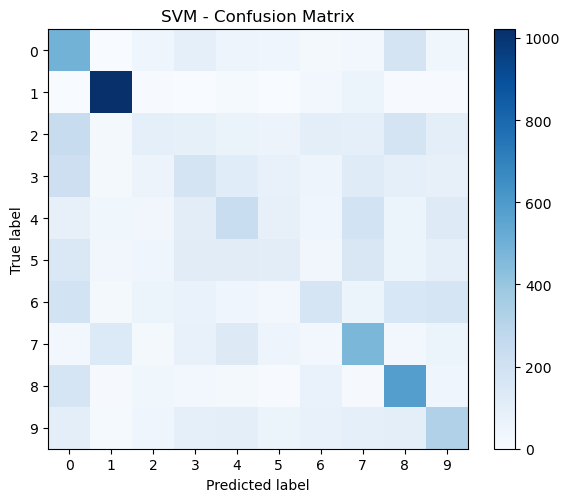

Training Naive Bayes...
Naive Bayes - Training time: 1.3287 seconds
Naive Bayes - Inference time: 0.0150 seconds
Naive Bayes - Average inference time per sample: 0.000001 seconds
Naive Bayes - Accuracy: 35.41%
Naive Bayes - Confusion Matrix:
[[ 279    0   49  124   36  247    5   22  182   36]
 [   3 1048    4    0   11    1   32   28    6    2]
 [ 106    6  127  111   42  225   36   67  217   95]
 [  71    4   50  199   66  314    7  125  121   53]
 [  70   10   46   88  121  312   17  164   50  104]
 [  34   14   29  116   46  394    4  133   63   59]
 [ 107    8   88   93   29  157   72   44  188  172]
 [  17  109   28   52   57  223   20  460   21   41]
 [  96    0   40   59   15   55   27    9  595   78]
 [  35    7   48  105   37  335   32   71   93  246]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.28      0.31       980
           1       0.87      0.92      0.90      1135
           2       0.25    

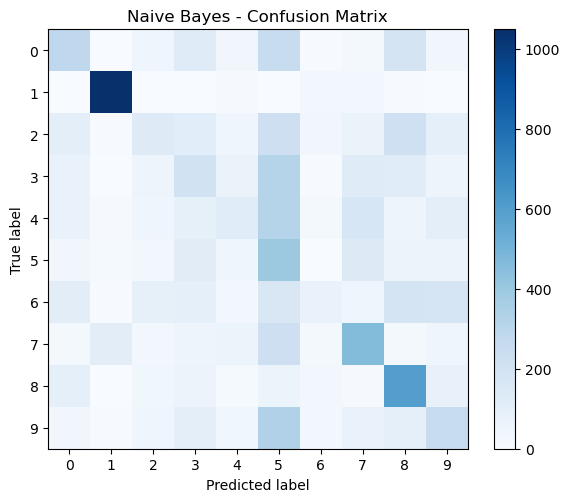

Training Random Forest...
Random Forest - Training time: 164.5570 seconds
Random Forest - Inference time: 1.0321 seconds
Random Forest - Average inference time per sample: 0.000103 seconds
Random Forest - Accuracy: 42.46%
Random Forest - Confusion Matrix:
[[ 512    0   66  111   24   44   43   18  125   37]
 [   1 1074    2    2    5    2   15   25    3    6]
 [ 126    4  200  141   78   68   94   84  143   94]
 [ 114    3   89  285   95  120   54  103   77   70]
 [  32   10   59  108  319   72   59  158   28  137]
 [  89    9   62  186   90  148   40  136   41   91]
 [ 123   11  103   67   72   41  209   46  125  161]
 [  13   58   30   59  105   42   21  624   12   64]
 [ 110    0   78   39   37   10   73   14  566   47]
 [  57    8   69  113  122   65  113   87   66  309]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.52      0.47       980
           1       0.91      0.95      0.93      1135
           

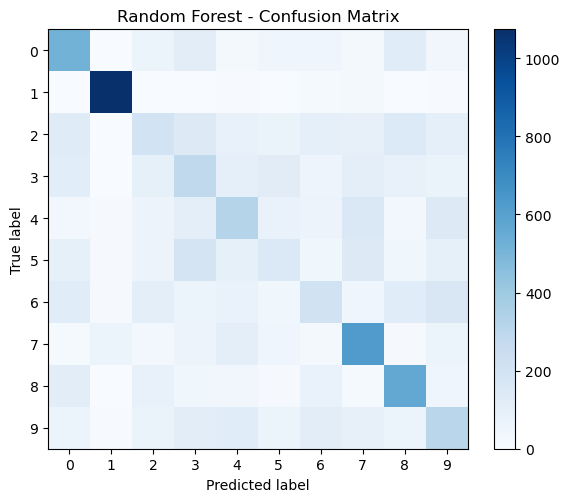

Training KNN...
KNN - Training time: 15.8672 seconds
KNN - Inference time: 4.4070 seconds
KNN - Average inference time per sample: 0.000441 seconds
KNN - Accuracy: 37.70%
KNN - Confusion Matrix:
[[ 540    0   85  117   19   56   48   14   82   19]
 [   1 1074    4    6    7    1   14   24    3    1]
 [ 180    6  227  160   82   95   67   47  104   64]
 [ 179    4  130  267   95  137   41   67   42   48]
 [  53    6  110  142  305   93   50  102   27   94]
 [ 122    5  114  205  101  140   48   83   24   50]
 [ 156   14  177  108   76   50  159   31   96   91]
 [  19   75   65  102  142   80   20  469    8   48]
 [ 161    1  150   67   40   21   85   11  410   28]
 [  89    6  109  145  156   96  121   58   50  179]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.55      0.44       980
           1       0.90      0.95      0.92      1135
           2       0.19      0.22      0.21      1032
           3       0.20     

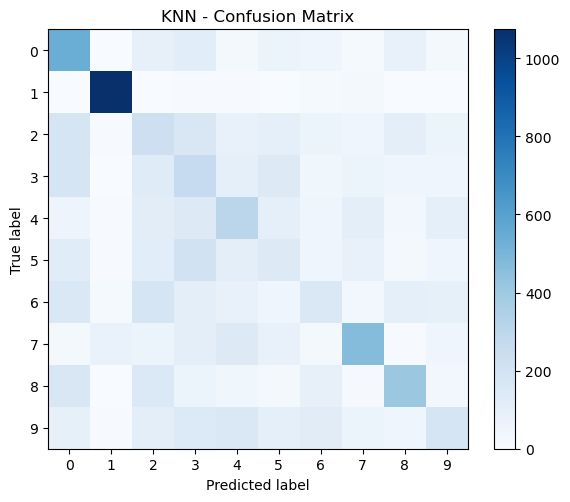

In [11]:
models_lbp = classifier_grid_search(x_train_lbp, y_train_lbp, x_test_lbp, y_test_lbp)
models['models_lbp'] = models_lbp

## GLCM


In [12]:
# Measure time for GLCM feature extraction
start = time.time()
x_train_glcm, y_train_glcm = get_fix_feature(image_path_train, 'glcm')
x_test_glcm, y_test_glcm = get_fix_feature(image_path_test, 'glcm')
end = time.time()
print(f"GLCM feature extraction time: {end - start:.2f} seconds")
logging.info(f"GLCM feature extraction time: {end - start:.2f} seconds")

GLCM feature extraction time: 5998.58 seconds


Training SVM...
SVM - Training time: 7912.6891 seconds
SVM - Inference time: 60.7970 seconds
SVM - Average inference time per sample: 0.006080 seconds
SVM - Accuracy: 19.26%
SVM - Confusion Matrix:
[[114  73  22 757   3   0   3   0   8   0]
 [152 616  26 278  42   0   3   0  18   0]
 [110 107  52 729   8   4   5   1  16   0]
 [ 91  45  21 830   6   4   4   1   8   0]
 [125 377  22 399  49   2   1   0   7   0]
 [ 89  60  23 682   5   4   5   2  22   0]
 [ 78 101  30 707   4   6  11   8  13   0]
 [ 94 284  16 375  40   2   2 209   6   0]
 [111 102  40 655  13   6   6   0  41   0]
 [ 89 301  19 481  39   1   4  68   7   0]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.12      0.11       980
           1       0.30      0.54      0.38      1135
           2       0.19      0.05      0.08      1032
           3       0.14      0.82      0.24      1010
           4       0.23      0.05      0.08       982
           5     

D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


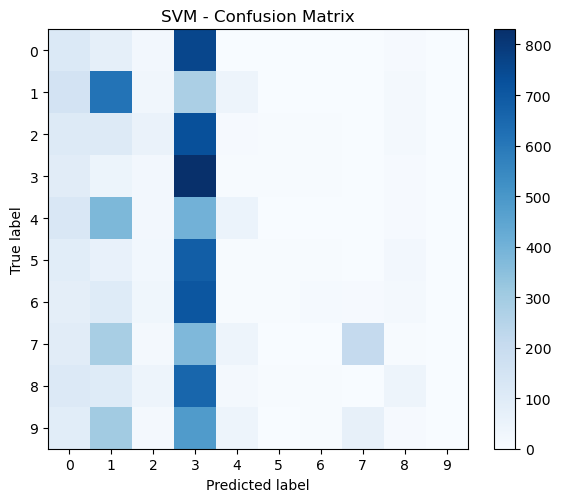

Training Naive Bayes...
Naive Bayes - Training time: 6.5489 seconds
Naive Bayes - Inference time: 0.0800 seconds
Naive Bayes - Average inference time per sample: 0.000008 seconds
Naive Bayes - Accuracy: 16.95%
Naive Bayes - Confusion Matrix:
[[134  73   3 690   1  38   0  23   3  15]
 [164 548   0 189   3  26   0 121   4  80]
 [135 137   9 643   6  40   0  27   5  30]
 [112  37   2 748   4  36   0  31   4  36]
 [138 352   3 311   5  14   0  77   1  81]
 [106  66   1 605   4  34   0  36   5  35]
 [114 101   3 605   8  55   0  27  11  34]
 [145 329   2 292   5  27   0 115   2 111]
 [130 131   6 552  10  63   0  42   5  35]
 [120 297   1 382   2  27   0  79   4  97]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.14      0.12       980
           1       0.26      0.48      0.34      1135
           2       0.30      0.01      0.02      1032
           3       0.15      0.74      0.25      1010
           4       

D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


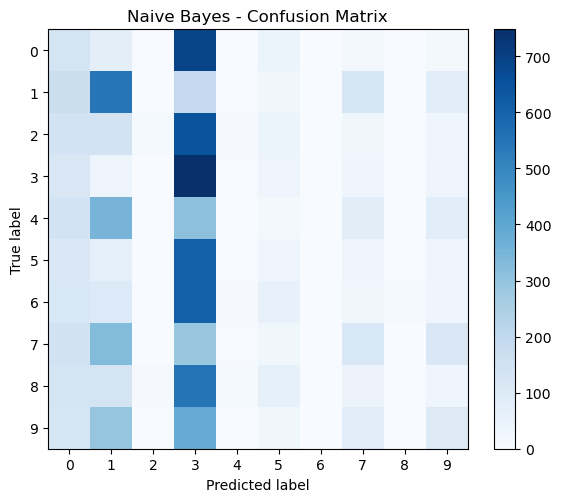

Training Random Forest...
Random Forest - Training time: 49.4919 seconds
Random Forest - Inference time: 0.2740 seconds
Random Forest - Average inference time per sample: 0.000027 seconds
Random Forest - Accuracy: 21.29%
Random Forest - Confusion Matrix:
[[268 113  42 402   5  50  62   9  20   9]
 [ 72 735  31 117  29  18  46  72   7   8]
 [223 161  63 362  10  76  80  26  19  12]
 [185  83  28 466   8  94  92  26  17  11]
 [113 442  40 172  42  26  35  79  13  20]
 [140 101  26 380   8  91  89  35  14   8]
 [168 131  30 380   9  67 111  31  21  10]
 [ 86 342  23 158  31  39  24 294  13  18]
 [168 165  40 321  13  59 133  29  37   9]
 [137 359  27 216  38  30  24 146  10  22]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.27      0.21       980
           1       0.28      0.65      0.39      1135
           2       0.18      0.06      0.09      1032
           3       0.16      0.46      0.23      1010
    

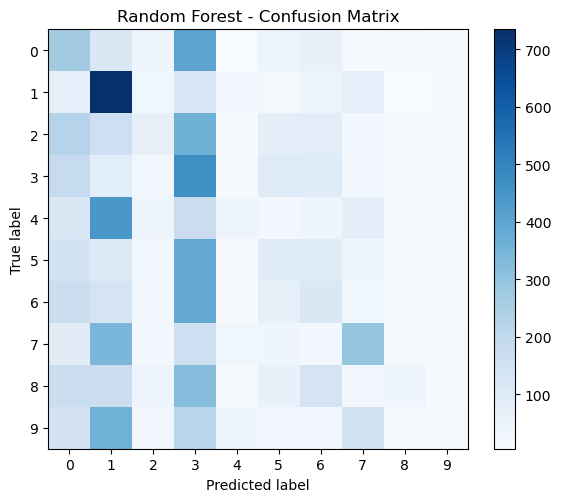

Training KNN...
KNN - Training time: 19.1092 seconds
KNN - Inference time: 1.5126 seconds
KNN - Average inference time per sample: 0.000151 seconds
KNN - Accuracy: 15.51%
KNN - Confusion Matrix:
[[889   8  68   0   1   0   0   0  11   3]
 [724 381  15   0   4   0   1   4   4   2]
 [910  31  79   0   0   0   0   0   9   3]
 [881  17  97   5   2   0   0   1   6   1]
 [664 271  34   1   7   0   0   1   0   4]
 [777  30  70   2   0   0   0   2   7   4]
 [841  24  64   4   3   4   2   2   9   5]
 [578 193  42   5  12  10  10 174   1   3]
 [877  37  45   1   1   1   2   0  10   0]
 [694 199  32   2   8   9   4  53   4   4]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.91      0.20       980
           1       0.32      0.34      0.33      1135
           2       0.14      0.08      0.10      1032
           3       0.25      0.00      0.01      1010
           4       0.18      0.01      0.01       982
           5       0

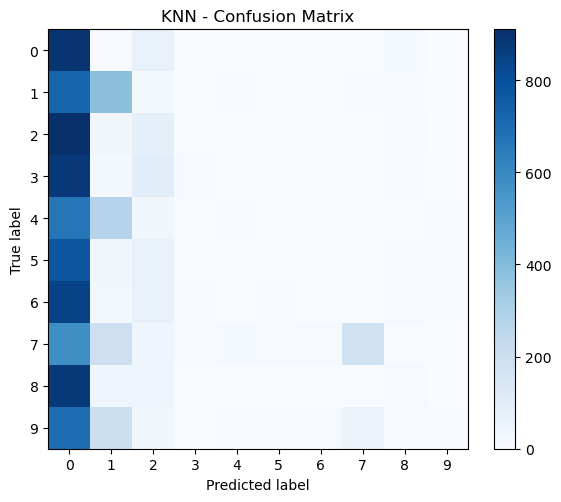

In [13]:
models_glmc = classifier_grid_search(x_train_glcm, y_train_glcm, x_test_glcm, y_test_glcm)
models['models_glmc'] = models_glmc

## ZM


In [14]:
# Measure time for ZM feature extraction
start = time.time()
x_train_zm, y_train_zm = get_fix_feature(image_path_train, 'zm')
x_test_zm, y_test_zm = get_fix_feature(image_path_test, 'zm')
end = time.time()
print(f"Zernike moments feature extraction time: {end - start:.2f} seconds")
logging.info(f"Zernike moments feature extraction time: {end - start:.2f} seconds")

Zernike moments feature extraction time: 55.66 seconds


Training SVM...
SVM - Training time: 337.3648 seconds
SVM - Inference time: 20.3367 seconds
SVM - Average inference time per sample: 0.002034 seconds
SVM - Accuracy: 76.48%
SVM - Confusion Matrix:
[[ 909    0    7   11    0   13    9    1   25    5]
 [   0 1108    6    0    6    4    1    9    0    1]
 [  17    8  623  116   70   87   35   35   34    7]
 [   6   10  119  647    9   43   24   25  115   12]
 [   5    6   92    5  746   18   21   39   11   39]
 [  26    5  102   47   35  586   31   30   17   13]
 [  11    7   31   24   29   20  745   12   12   67]
 [   4   22   36   18   61   13   13  824    4   33]
 [   9    0   42   72   31   17   33    9  749   12]
 [   7    5   22   13   80   39   81   34   17  711]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.95      0.98      0.96      1135
           2       0.58      0.60      0.59      1032
           3       0.68   

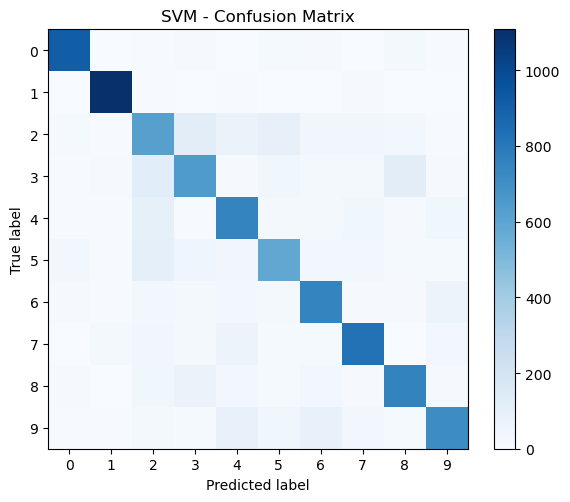

Training Naive Bayes...
Naive Bayes - Training time: 0.4655 seconds
Naive Bayes - Inference time: 0.0419 seconds
Naive Bayes - Average inference time per sample: 0.000004 seconds
Naive Bayes - Accuracy: 61.96%
Naive Bayes - Confusion Matrix:
[[ 844    2    6   29    1   46   17    3   29    3]
 [   0 1061    2    2    1   11    0    7   47    4]
 [  38   15  460  141   97   66   13   99   83   20]
 [  66   25   96  431    5   61   19   51  219   37]
 [  18   14   86    2  546   26   31   76   32  151]
 [ 132   29   62   62   23  345   12   96   98   33]
 [  43   27   42   24   16    9  552   63   19  163]
 [   4   86   65   11   45   41   31  627   16  102]
 [  92    4   35   53   29   30   18   16  661   36]
 [  29   13   17   12   87   26  100   31   25  669]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       980
           1       0.83      0.93      0.88      1135
           2       0.53    

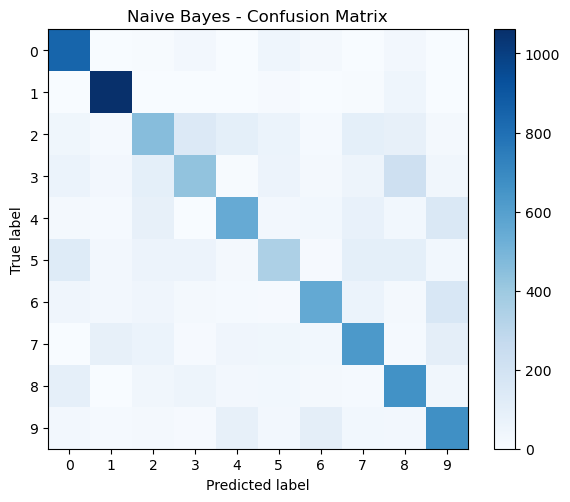

Training Random Forest...
Random Forest - Training time: 1204.7125 seconds
Random Forest - Inference time: 0.8900 seconds
Random Forest - Average inference time per sample: 0.000089 seconds
Random Forest - Accuracy: 82.47%
Random Forest - Confusion Matrix:
[[ 931    0    5    6    0    8   12    3   11    4]
 [   0 1113    3    1    2    1    2    9    1    3]
 [  11    3  714   73   55   79   31   31   27    8]
 [   3    6   53  767    6   34   21   35   78    7]
 [   0    0   62    1  820   19   18   21    6   35]
 [  19    2   65   36   23  669   26   32   11    9]
 [  10    4   15   29   11   10  788   24    6   61]
 [   4    6   23   12   35   10   14  876   11   37]
 [   5    1   25   81   23   10   33    6  778   12]
 [   5    5   13   16   61   21   65   17   15  791]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.98      0.98      0.98      1135
          

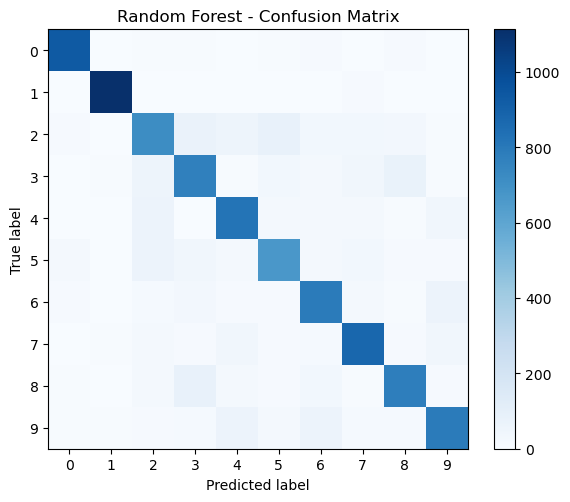

Training KNN...
KNN - Training time: 5.7789 seconds
KNN - Inference time: 1.2640 seconds
KNN - Average inference time per sample: 0.000126 seconds
KNN - Accuracy: 84.02%
KNN - Confusion Matrix:
[[ 947    0    6    4    0    3   11    0    7    2]
 [   0 1116    3    1    4    1    4    5    1    0]
 [  14    2  733   54   58   56   37   29   31   18]
 [   4    6   42  779    3   25   41   17   79   14]
 [   0    0   61    3  799   10   18   16    6   69]
 [  16    4   68   48   17  667   23   20   10   19]
 [   9    5   12   22    7    8  814   16    2   63]
 [   4   12   19   10   21   12   22  890    9   29]
 [   5    0   18   54   13   13   35    5  814   17]
 [   3    5   13   10   25   16   70   12   12  843]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.75      0.71      0.73      1032
           3       0.79      

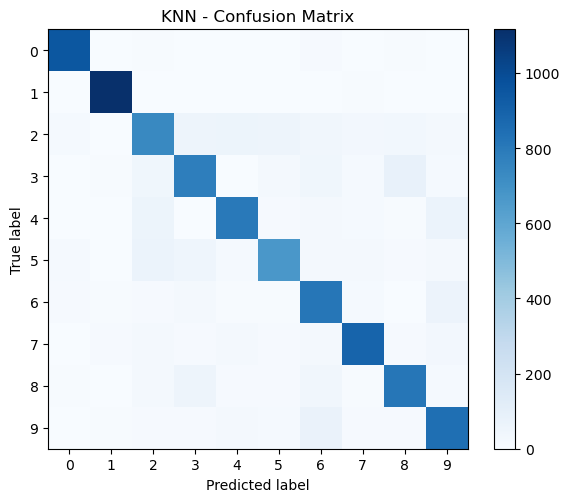

In [15]:
models_zm = classifier_grid_search(x_train_zm, y_train_zm, x_test_zm, y_test_zm)

## HOG + LBP


In [16]:
# Measure time for feature combination
start = time.time()
x_combined_train_hog_lbp = feature_combiner(x_train_hog, x_train_lbp)
x_combined_test_hog_lbp = feature_combiner(x_test_hog, x_test_lbp)
y_combined_train_hog_lbp = y_train_hog  # Assuming labels remain the same
y_combined_test_hog_lbp = y_test_hog
end = time.time()
print(f"Combined (HOG + LBP) feature extraction time: {end - start:.2f} seconds")
logging.info(f"Combined (HOG + LBP) feature extraction time: {end - start:.2f} seconds")

Combined (HOG + LBP) feature extraction time: 0.46 seconds


Training SVM...
SVM - Training time: 409.5587 seconds
SVM - Inference time: 45.8531 seconds
SVM - Average inference time per sample: 0.004585 seconds
SVM - Accuracy: 97.64%
SVM - Confusion Matrix:
[[ 972    0    1    0    0    0    3    2    2    0]
 [   1 1123    2    1    0    0    2    1    5    0]
 [   2    2 1013    4    0    0    0    8    1    2]
 [   2    0    7  978    0   10    0    4    7    2]
 [   3    1    2    2  953    1    4    0    2   14]
 [   2    1    1   13    0  870    2    0    1    2]
 [   5    3    1    0    2    3  943    0    1    0]
 [   0    4    7    2    5    0    0 1000    3    7]
 [   4    1    4    5    3    5    1    4  942    5]
 [   2    6    1    7    8    3    0    9    3  970]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97   

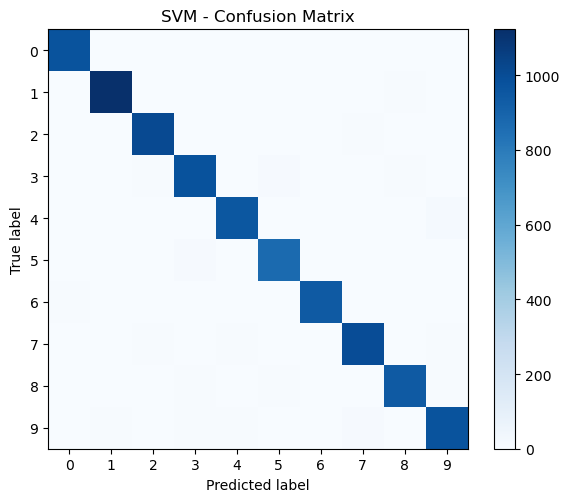

Training Naive Bayes...
Naive Bayes - Training time: 3.5210 seconds
Naive Bayes - Inference time: 0.7674 seconds
Naive Bayes - Average inference time per sample: 0.000077 seconds
Naive Bayes - Accuracy: 78.92%
Naive Bayes - Confusion Matrix:
[[790   1  13  51   0   6  65   3  30  21]
 [  0 974  19   9  10   5  13  28  43  34]
 [ 10   3 869  57   8   0  21  20  34  10]
 [  3   2  31 864   5   7  11  44  14  29]
 [  2   2  27  10 566  11  18  75  18 253]
 [  5   0  15 160   4 533  31   7  92  45]
 [  8   4  16   3   0   9 902   0  15   1]
 [  0   4   9  11  14   1   0 850  12 127]
 [  9   1  11 109  10  31   8  19 630 146]
 [  2   1   5  16  14   0   0  49   8 914]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       980
           1       0.98      0.86      0.92      1135
           2       0.86      0.84      0.85      1032
           3       0.67      0.86      0.75      1010
           4       

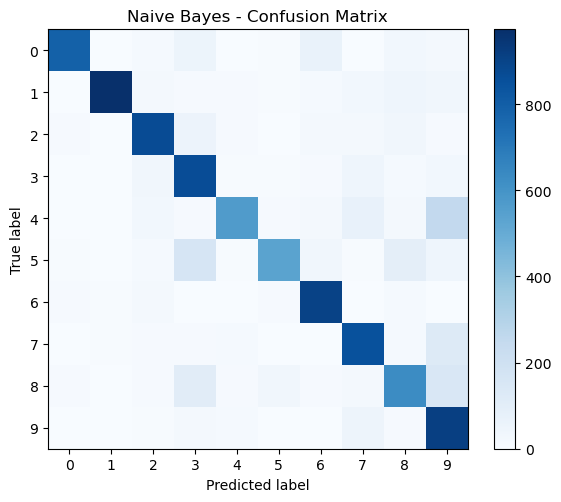

Training Random Forest...
Random Forest - Training time: 4788.9450 seconds
Random Forest - Inference time: 1.1930 seconds
Random Forest - Average inference time per sample: 0.000119 seconds
Random Forest - Accuracy: 96.44%
Random Forest - Confusion Matrix:
[[ 965    1    4    1    0    1    6    0    2    0]
 [   0 1110    8    0    0    0    6    2    9    0]
 [   8    5 1002    5    1    0    4    4    3    0]
 [   0    0    9  976    1    9    0    5    6    4]
 [   1    2    4    0  946    1    6    2    2   18]
 [   4    1    2   21    2  849    9    0    1    3]
 [   7    3    0    0    3    6  936    0    3    0]
 [   1    6   13    0    4    0    0  986    2   16]
 [  11    1    8   10    7   10    5    5  915    2]
 [  10    4    4   12    6    1    0    7    6  959]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
          

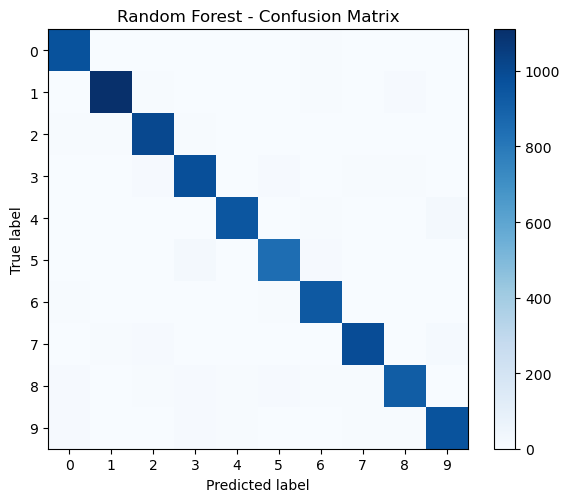

Training KNN...
KNN - Training time: 95.7129 seconds
KNN - Inference time: 7.7822 seconds
KNN - Average inference time per sample: 0.000778 seconds
KNN - Accuracy: 92.79%
KNN - Confusion Matrix:
[[ 943    2    3    2    0    3   22    3    2    0]
 [   0 1117    7    1    0    2    5    1    2    0]
 [  20    2  942   22    7    0   10   17    8    4]
 [   6    3   20  932    1    9    5   16   14    4]
 [   5   13   11    2  888    1   13   12    1   36]
 [   4    1    3   34    5  813   21    0    8    3]
 [  20    5    3    1    3    9  914    0    3    0]
 [   5   16   16    6    8    0    0  928    5   44]
 [  29    4    7   14   10   13    7    8  875    7]
 [   6    8    4   11   11    5    0   30    7  927]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       980
           1       0.95      0.98      0.97      1135
           2       0.93      0.91      0.92      1032
           3       0.91     

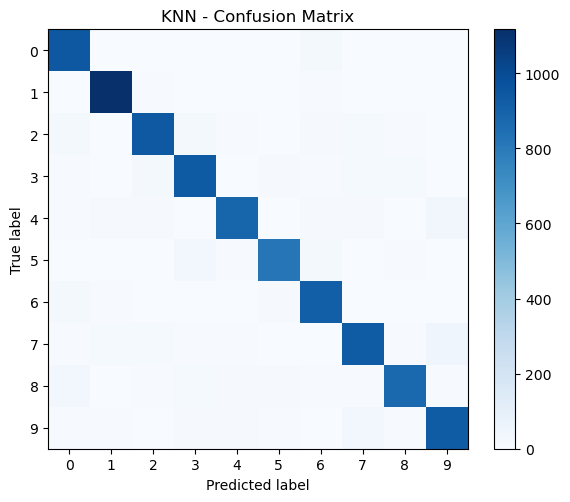

In [17]:
models_hog_lbp = classifier_grid_search(x_combined_train_hog_lbp, y_combined_train_hog_lbp, x_combined_test_hog_lbp, y_combined_test_hog_lbp)
models['models_hog_lbp'] = models_hog_lbp

## HOG + GLCM


In [18]:
# Measure time for feature combination
start = time.time()
x_combined_train_hog_glcm = feature_combiner(x_train_hog, x_train_glcm)
x_combined_test_hog_glcm = feature_combiner(x_test_hog, x_test_glcm)
y_combined_train_hog_glcm = y_train_hog  # Assuming labels remain the same
y_combined_test_hog_glcm = y_test_hog
end = time.time()
print(f"Combined (HOG + GLCM) feature extraction time: {end - start:.2f} seconds")
logging.info(f"Combined (HOG + GLCM) feature extraction time: {end - start:.2f} seconds")

Combined (HOG + GLCM) feature extraction time: 0.52 seconds


Training SVM...
SVM - Training time: 457.4534 seconds
SVM - Inference time: 49.9503 seconds
SVM - Average inference time per sample: 0.004995 seconds
SVM - Accuracy: 97.50%
SVM - Confusion Matrix:
[[ 970    1    2    0    0    0    3    1    3    0]
 [   1 1124    2    1    0    0    1    1    5    0]
 [   2    2 1012    5    0    0    0    7    3    1]
 [   2    1    4  982    0   10    0    3    6    2]
 [   2    2    1    1  956    1    3    0    2   14]
 [   1    2    1   15    0  867    2    0    2    2]
 [   5    3    1    0    2    4  942    0    1    0]
 [   0    6    8    3    6    1    0  992    3    9]
 [   3    3    4    7    3    4    1    5  939    5]
 [   2    4    2    7   10    3    0    9    6  966]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.98      0.98      1032
           3       0.96   

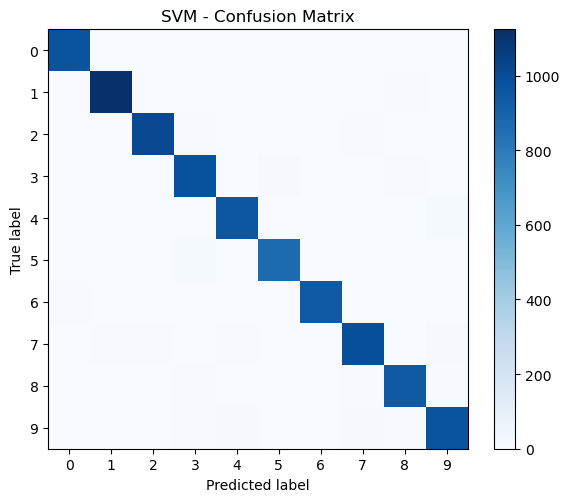

Training Naive Bayes...
Naive Bayes - Training time: 3.5455 seconds
Naive Bayes - Inference time: 0.7290 seconds
Naive Bayes - Average inference time per sample: 0.000073 seconds
Naive Bayes - Accuracy: 77.97%
Naive Bayes - Confusion Matrix:
[[ 769    3   14   54    0    6   69    2   41   22]
 [   0 1025   17    5    9    2   14   18   27   18]
 [   9    4  861   56   10    0   24   23   36    9]
 [   3    3   32  858    4    7   11   45   19   28]
 [   3    8   25    9  550    9   19   78   14  267]
 [   5    1   16  167    5  513   33    8   99   45]
 [   7    4   17    4    1    9  905    0   10    1]
 [   0    9    8    9   14    1    0  817   12  158]
 [  10    5   11  132    8   30   10   22  576  170]
 [   2    2    5   19   10    0    0   44    4  923]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       980
           1       0.96      0.90      0.93      1135
           2       0.86    

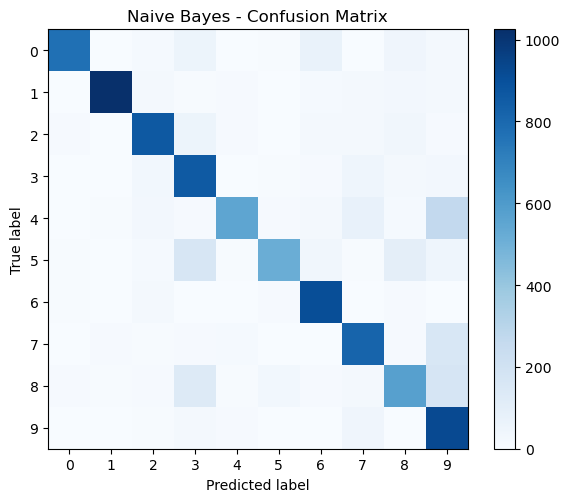

Training Random Forest...
Random Forest - Training time: 4875.5779 seconds
Random Forest - Inference time: 1.2950 seconds
Random Forest - Average inference time per sample: 0.000130 seconds
Random Forest - Accuracy: 96.40%
Random Forest - Confusion Matrix:
[[ 965    3    2    1    0    1    5    1    2    0]
 [   1 1109    7    0    1    0    6    3    8    0]
 [   8    5 1001    3    3    0    3    4    4    1]
 [   0    0    9  976    2   11    0    5    3    4]
 [   1    2    2    1  953    0    7    0    1   15]
 [   5    1    3   21    2  845    8    0    4    3]
 [   8    5    0    0    3    5  932    0    5    0]
 [   0    6   12    2    7    0    0  988    3   10]
 [  13    1   10    9    7    7    4    4  918    1]
 [   8    6    4   17    6    1    0    8    6  953]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.98      1135
          

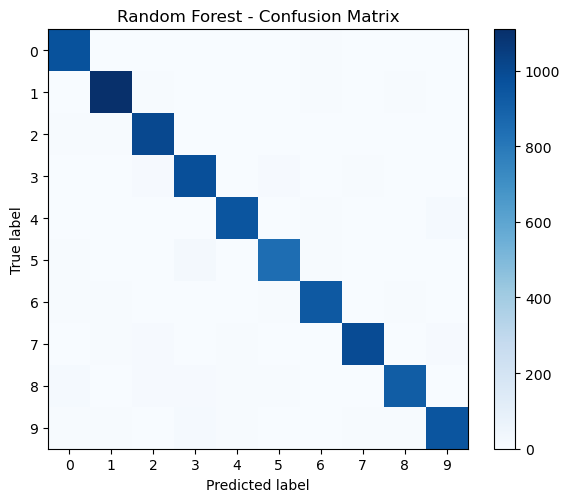

Training KNN...
KNN - Training time: 100.6822 seconds
KNN - Inference time: 8.1196 seconds
KNN - Average inference time per sample: 0.000812 seconds
KNN - Accuracy: 91.55%
KNN - Confusion Matrix:
[[ 939    4    3    3    1    4   21    3    2    0]
 [   1 1115    6    1    0    1    8    2    1    0]
 [  19    9  925   28    7    0   10   21   10    3]
 [   4   10   19  920    1   13    6   15   19    3]
 [   5   21    9    2  873    1   11   10    1   49]
 [   7    5    3   36    5  794   22    1   14    5]
 [  19    6    4    1    2   11  911    0    4    0]
 [   3   19   12    5   12    1    0  920    3   53]
 [  28   10   11   15   10   30    8   10  842   10]
 [   4   16    4   14    8    6    0   32    9  916]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       980
           1       0.92      0.98      0.95      1135
           2       0.93      0.90      0.91      1032
           3       0.90    

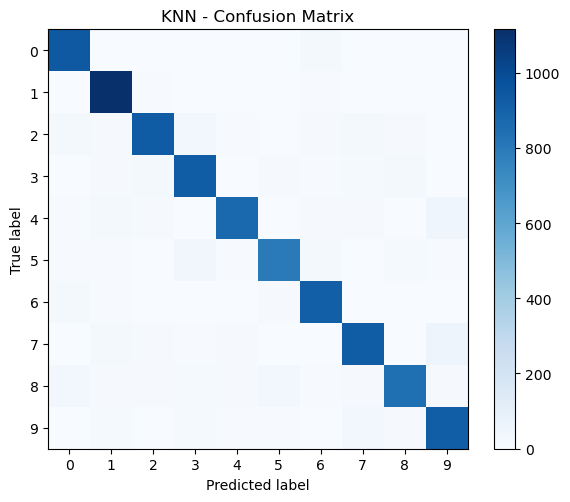

In [19]:
models_hog_glcm = classifier_grid_search(x_combined_train_hog_glcm, y_combined_train_hog_glcm, x_combined_test_hog_glcm, y_combined_test_hog_glcm)
models['models_hog_glcm'] = models_hog_glcm

## SIFT


In [20]:

# Measure time for SIFT feature extraction
start = time.time()
x_train_sift, y_train_sift = get_SIFT_feature(image_path_train)
x_test_sift, y_test_sift = get_SIFT_feature(image_path_test)
end = time.time()
print(f"SIFT feature extraction time: {end - start:.2f} seconds")
logging.info(f"SIFT feature extraction time: {end - start:.2f} seconds")


SIFT feature extraction time: 351.79 seconds


Training SVM...
SVM - Training time: 1841.1305 seconds
SVM - Inference time: 78.3245 seconds
SVM - Average inference time per sample: 0.007832 seconds
SVM - Accuracy: 10.39%
SVM - Confusion Matrix:
[[  7   2  64 123  64  39 265 231  66 119]
 [  1  28 350  23  22  53 434  85  16 123]
 [  9   2 158  95  62  76 225 120  66 219]
 [ 15   0 178  59  96 105 128  79  66 284]
 [ 19   6 214  58 200 213 126  59  31  56]
 [  9   4 151  93  76 173 131  68  45 142]
 [ 54  11 165  71  91  80 213 105  67 101]
 [  3   0 163  35  49 109 315  43  53 258]
 [ 28   2 170  65 134 153 126 129 117  50]
 [ 19  15 191  65 131  66 161 228  92  41]]
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.01      0.01       980
           1       0.40      0.02      0.05      1135
           2       0.09      0.15      0.11      1032
           3       0.09      0.06      0.07      1010
           4       0.22      0.20      0.21       982
           5     

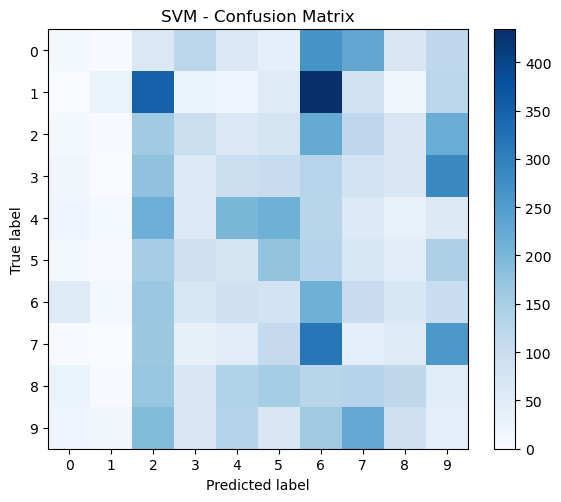

Training Naive Bayes...
Naive Bayes - Training time: 2.0000 seconds
Naive Bayes - Inference time: 0.2290 seconds
Naive Bayes - Average inference time per sample: 0.000023 seconds
Naive Bayes - Accuracy: 11.36%
Naive Bayes - Confusion Matrix:
[[   0    0    0    0    1    1    0  886    0   92]
 [   0    5    0    0    0   58    0 1066    5    1]
 [   0    0    0    0    0    0   11  924    0   97]
 [   0    0    0    0    0    1    2  898    0  109]
 [   0    1    0    0    7   30   16  925    0    3]
 [   0    0    0    0    2   12    5  819    0   54]
 [   0    1    0    0    0    0   12  792    0  153]
 [   0    0    0    0    0    3    0 1000    1   24]
 [   0    0    0    0    0    2    3  891    0   78]
 [   0    2    0    0    1    0    8  898    0  100]]
Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.56      0.00      0.01      1135
           2       0.00    

D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\software\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


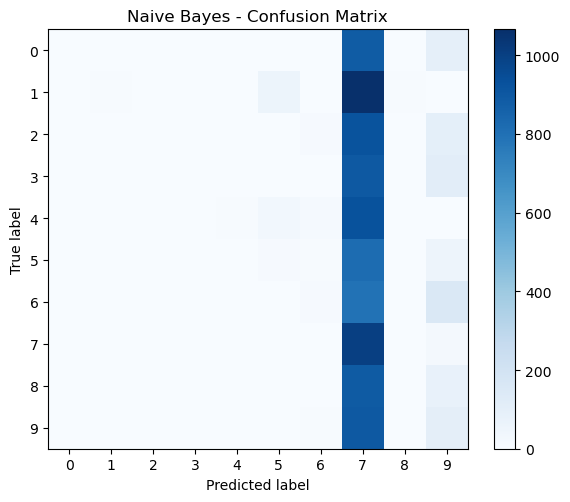

Training Random Forest...
Random Forest - Training time: 291.6724 seconds
Random Forest - Inference time: 1.9965 seconds
Random Forest - Average inference time per sample: 0.000200 seconds
Random Forest - Accuracy: 10.12%
Random Forest - Confusion Matrix:
[[ 68 124  93  55  28  14 342 178  53  25]
 [ 74 331 105  21   4  10 259  13   9 309]
 [142 215 101  41  29  26 261  55  41 121]
 [124 146 146  32  55  48 172  40  56 191]
 [247 196 110  30  78 160  78  12  22  49]
 [139  94 157  42  34  56 191  53  38  88]
 [148 187 128  39  57  30 228  52  35  54]
 [103 218  61  37  14  10 355  12  39 179]
 [143 165 147  27  81  56 183  70  82  20]
 [209 289 145  20  33  33 118  66  72  24]]
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.07      0.06       980
           1       0.17      0.29      0.21      1135
           2       0.08      0.10      0.09      1032
           3       0.09      0.03      0.05      1010
   

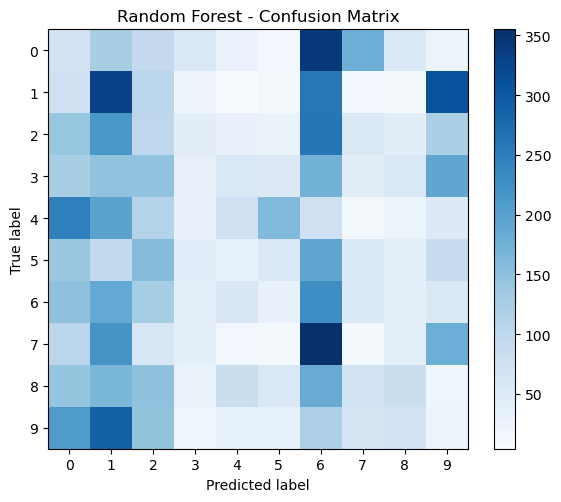

Training KNN...
KNN - Training time: 44.5253 seconds
KNN - Inference time: 3.2261 seconds
KNN - Average inference time per sample: 0.000323 seconds
KNN - Accuracy: 8.12%
KNN - Confusion Matrix:
[[159 128  17  57  58  11 397  61  48  44]
 [390  94  45  33   2  87 130  42  13 299]
 [321 108  49  43  31  15 347  39  34  45]
 [307 146  27  17  35  30 271  25  47 105]
 [391 223  88  32  54  12 138  19  11  14]
 [308  77  41  47  39  22 258  34  23  43]
 [191 130  58  30  62  54 295  74  41  23]
 [309  47  48  17  31  26 340  24  37 149]
 [213 132  92  26  81  84 198  59  75  14]
 [210 220  57  16  32  17 245 123  66  23]]
KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.16      0.08       980
           1       0.07      0.08      0.08      1135
           2       0.09      0.05      0.06      1032
           3       0.05      0.02      0.03      1010
           4       0.13      0.05      0.08       982
           5       0.

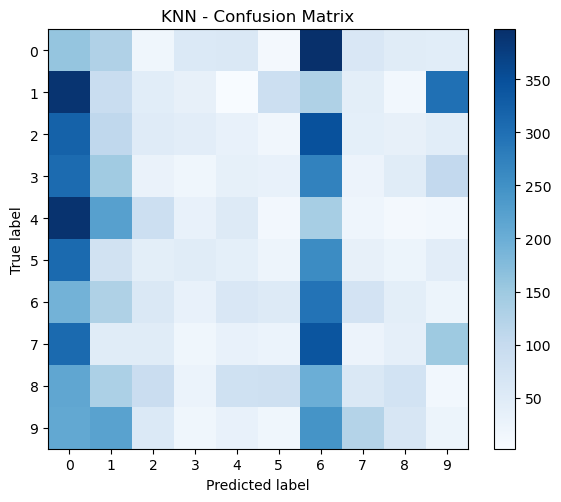

In [21]:
models_sift = classifier_grid_search(x_train_sift, y_train_sift, x_test_sift, y_test_sift)
models['models_sift'] = models_sift

In [22]:
# save models

for name, model in models.items():
    joblib.dump(model, f'{name}.pkl')  
    print(f"Model {name} saved to {name}.pkl")

Model models_hog saved to models_hog.pkl
Model models_lbp saved to models_lbp.pkl
Model models_glmc saved to models_glmc.pkl
Model models_hog_lbp saved to models_hog_lbp.pkl
Model models_hog_glcm saved to models_hog_glcm.pkl
Model models_sift saved to models_sift.pkl


In [23]:
logging.info("*****************This is the end of this traning********************")

In [24]:
feature_dic = {
    'x_train_lbp': x_train_lbp,
    'y_train_lbp': y_train_lbp,
    'x_test_lbp': x_test_lbp,
    'y_test_lbp': y_test_lbp,
    'x_train_hog': x_train_hog,
    'y_train_hog': y_train_hog,
    'x_test_hog': x_test_hog,
    'y_test_hog': y_test_hog,
    'x_train_glcm': x_train_glcm,
    'y_train_glcm': y_train_glcm,
    'x_test_glcm': x_test_glcm,
    'y_test_glcm': y_test_glcm,
    'x_train_zm': x_train_zm,
    'y_train_zm': y_train_zm,
    'x_test_zm': x_test_zm,
    'y_test_zm': y_test_zm,
    'x_combined_train_hog_lbp': x_combined_train_hog_lbp,
    'y_combined_train_hog_lbp': y_combined_train_hog_lbp,
    'x_combined_test_hog_lbp': x_combined_test_hog_lbp,
    'y_combined_test_hog_lbp': y_combined_test_hog_lbp,
    'x_combined_train_hog_glcm': x_combined_train_hog_glcm,
    'y_combined_train_hog_glcm': y_combined_train_hog_glcm,
    'x_combined_test_hog_glcm': x_combined_test_hog_glcm,
    'y_combined_test_hog_glcm': y_combined_test_hog_glcm,
    'x_train_sift': x_train_sift,
    'y_train_sift': y_train_sift,
    'x_test_sift': x_test_sift,
    'y_test_sift': y_test_sift,
    
}

joblib.dump(feature_dic, "features_mnist-hand.pkl")

print("Features saved successfully with joblib!")

Features saved successfully with joblib!
